### **Libraries**

In [63]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from time import time

In [64]:
import tensorflow as tf

### **Global Variables**

#### **Physics Related Constants**

In [65]:
alpha = 0.0801 * 1e6
k     = 0.05 * 1e3
v     = 10.0 * 1e-3
m     = 0.6
n     = 0.4
Q     = 1652.4
a_f   = 1.002 * 1e-3
a_r   = 3.34 * 1e-3
b     = 1.67 * 1e-3
c     = 1.67 * 1e-3
h     = 20e-6 * 1e6
T_0   = 293.15
T_MAX = 1723

#### **PINN Related**

In [66]:
SEED       = 42
BATCH_SIZE = 256
DEBUG      = False

In [67]:
"""
Strings that can be used as keys in inputParams dict
"""

INPUT_LAYER_DIM         = "inputLayerDim"
OUTPUT_LAYER_DIM        = "outputLayerDim"
HIDDEN_LAYERS_DIM       = "hiddenLayersDim"
ANALYTICAL_SOLUTION     = "analyticalSolution"
RESIDUAL                = "residual"
EVALUATE_RESIDUAL       = "evaluateResidual"
EVALUATE_BOUNDARY_EQN_1 = "evaluateBoundaryEqn_1"
EVALUATE_BOUNDARY_EQN_2 = "evaluateBoundaryEqn_2"
EVALUATE_BOUNDARY_EQN_3 = "evaluateBoundaryEqn_3"
LEARNING_RATE           = "learningRate"
EPOCHS                  = "epochs"
PRINT_INTERVAL          = "print_interval"
TRAINING_POINTS         = "trainingPoints"
TRAINING_LABELS         = "trainingLabels"
TEST_POINTS             = "testPoints"
TEST_LABELS             = "testLabels"
COLLOCATION_POINTS      = "collocationPoints"
INITIAL_POINTS          = "initialPoints"
INITIAL_LABELS          = "initialLabels"
BOUNDARY_POINTS_1       = "boundaryPoints_1"
BOUNDARY_LABELS_1       = "boundaryLabels_1"
BOUNDARY_POINTS_2       = "boundaryPoints_2"
BOUNDARY_LABELS_2       = "boundaryLabels_2"
BOUNDARY_POINTS_3       = "boundaryPoints_3"
BOUNDARY_LABELS_3       = "boundaryLabels_3"
TRAINING_LOSS_WEIGHT    = "trainingLossWeight"
COLLOCATION_LOSS_WEIGHT = "collocationLossWeight"
INITIAL_LOSS_WEIGHT     = "initialLossWeight"
BOUNDARY_LOSS_WEIGHT    = "boundaryLossWeight"

### **PDE Specific Functions**

In [68]:
def analyticalSolution():
    pass

In [69]:
# def residual(T, x, t, dT_dt, dT_dx_2):
#     zeta = x - v*t 
#     q_f = ((6*np.sqrt(3)*Q*m / np.pi*np.sqrt(np.pi)*a_f*b*c) * tf.math.exp(-(3*zeta**2)/(a_f**2)))
#     q_r = ((6*np.sqrt(3)*Q*n / np.pi*np.sqrt(np.pi)*a_r*b*c) * tf.math.exp(-(3*zeta**2)/(a_r**2)))
#     q = q_f + q_r
#     return (dT_dx_2 + (q/k) - alpha*dT_dt)

# def residual(phi, zeta, dphi_dzeta_2):
#     """
#     PDE involving zeta, t, phi
#     """
#     q_f = ((6*np.sqrt(3)*Q*m / np.pi*np.sqrt(np.pi)*a_f*b*c) * tf.math.exp(-(3*zeta**2)/(a_f**2)))
#     q_r = ((6*np.sqrt(3)*Q*n / np.pi*np.sqrt(np.pi)*a_r*b*c) * tf.math.exp(-(3*zeta**2)/(a_r**2)))
#     q = q_f + q_r

#     return (dphi_dzeta_2 + (q/k)*tf.math.exp((v*alpha*zeta)/2) - (((alpha**2)*(v**2))/4)*phi)

def residual(phi, zeta, y, z, dphi_dzeta_2, dphi_dy_2, dphi_dz_2):
    """
    PDE involving zeta, y, z, t, phi
    """
    q_f = ((6*np.sqrt(3)*Q*m / np.pi*np.sqrt(np.pi)*a_f*b*c) * tf.math.exp(-(3*zeta**2)/(a_f**2) -(3*y**2)/(b**2) -(3*z**2)/(c**2)))
    q_r = ((6*np.sqrt(3)*Q*n / np.pi*np.sqrt(np.pi)*a_r*b*c) * tf.math.exp(-(3*zeta**2)/(a_r**2) -(3*y**2)/(b**2) -(3*z**2)/(c**2)))
    q = q_f + q_r
    return (dphi_dzeta_2 + dphi_dy_2 + dphi_dz_2 + (q/k)*tf.math.exp((v*alpha*zeta)/2) - (((alpha**2)*(v**2))/4)*phi)

# def residual(phi, zeta, dT_dzeta_1, dT_dzeta_2, dT_dt_1):
#     """
#     PDE involving zeta, t, T
#     """
#     q_f = ((6*np.sqrt(3)*Q*m / np.pi*np.sqrt(np.pi)*a_f*b*c) * tf.math.exp(-(3*zeta**2)/(a_f**2)))
#     q_r = ((6*np.sqrt(3)*Q*n / np.pi*np.sqrt(np.pi)*a_r*b*c) * tf.math.exp(-(3*zeta**2)/(a_r**2)))
#     q = q_f + q_r
#     return (dT_dzeta_2 + (q/k) + alpha*v*dT_dzeta_1, - alpha*dT_dt_1)

In [70]:
def evaluateResidual(model, X_r):
    """
    Evaluates residual involving zeta, y, t, phi
    """

    with tf.GradientTape(persistent=True) as tape:
        x, y, z, t, zeta = X_r[:, 0:1], X_r[:, 1:2], X_r[:, 2:3], X_r[:, 3:4], X_r[:, 4:5]
        
        tape.watch(x)
        tape.watch(y)
        tape.watch(z)
        tape.watch(t)
        tape.watch(zeta)
        
        phi = model(tf.stack([x[:, 0], y[:, 0], z[:, 0], t[:, 0], zeta[:, 0]], axis=1))
        
        dphi_dzeta_1 = tape.gradient(phi, zeta)
        dphi_dy_1 = tape.gradient(phi, y)
        dphi_dz_1 = tape.gradient(phi, z)
        
    dphi_dzeta_2 = tape.gradient(dphi_dzeta_1, zeta)
    dphi_dy_2 = tape.gradient(dphi_dy_1, y)
    dphi_dz_2 = tape.gradient(dphi_dz_1, z)

    del tape
    
    return residual(phi, zeta, y, z, dphi_dzeta_2, dphi_dy_2, dphi_dz_2)

# def evaluateResidual(model, X_r):
#     """
#     Evaluates residual involving zeta, phi
#     """

#     with tf.GradientTape(persistent=True) as tape:
#         x, t, zeta = X_r[:, 0:1], X_r[:, 1:2], X_r[:, 2:3]
        
#         tape.watch(x)
#         tape.watch(t)
#         tape.watch(zeta)
        
#         T = model(tf.stack([x[:, 0], t[:, 0], zeta[:, 0]], axis=1))
        
#         dT_dzeta_1 = tape.gradient(T, zeta)
#         dT_dt_1 = tape.gradient(T, t)
        
#     dT_dzeta_2 = tape.gradient(dT_dzeta_1, zeta)   

#     del tape
    
#     return residual(T, zeta, dT_dzeta_1, dT_dzeta_2, dT_dt_1)

In [71]:
def evaluateBoundaryEqn_1(model, X_b):
    """
    Evaluates residual involving zeta, y, t, phi
    """
    
    with tf.GradientTape(persistent=True) as tape:
        x, y, z, t, zeta = X_b[:, 0:1], X_b[:, 1:2], X_b[:, 2:3], X_b[:, 3:4], X_b[:, 4:5]

        tape.watch(x)
        tape.watch(y)
        tape.watch(z)
        tape.watch(t)
        tape.watch(zeta)

        phi = model(tf.stack([x[:, 0], y[:, 0], z[:, 0], t[:, 0], zeta[:, 0]], axis=1))

    dphi_dx_1 = tape.gradient(phi, x)

    del tape

    return dphi_dx_1 - (v*alpha*phi)/2 + (h*phi)/k

In [72]:
def evaluateBoundaryEqn_2(model, X_b):
    """
    Evaluates residual involving zeta, y, t, phi
    """

    with tf.GradientTape(persistent=True) as tape:
        x, y, z, t, zeta = X_b[:, 0:1], X_b[:, 1:2], X_b[:, 2:3], X_b[:, 3:4], X_b[:, 4:5]

        tape.watch(x)
        tape.watch(y)
        tape.watch(z)
        tape.watch(t)
        tape.watch(zeta)

        phi = model(tf.stack([x[:, 0], y[:, 0], z[:, 0], t[:, 0], zeta[:, 0]], axis=1))

    dphi_dx_1 = tape.gradient(phi, x)

    del tape

    return (-dphi_dx_1) + (v*alpha*phi)/2 + (h*phi)/k

In [73]:
def evaluateBoundaryEqn_3(model, X_b):
    """
    Evaluates residual involving zeta, y, t, phi
    """

    with tf.GradientTape(persistent=True) as tape:
        x, y, z, t, zeta = X_b[:, 0:1], X_b[:, 1:2], X_b[:, 2:3], X_b[:, 3:4], X_b[:, 4:5]

        tape.watch(x)
        tape.watch(y)
        tape.watch(z)
        tape.watch(t)
        tape.watch(zeta)

        phi = model(tf.stack([x[:, 0], y[:, 0], z[:, 0], t[:, 0], zeta[:, 0]], axis=1))

    dphi_dz_1 = tape.gradient(phi, z)

    del tape

    return dphi_dz_1

### **PINN**


In [74]:
class PINN:

    def __init__ (self, inputParams):
        
        self.inputLayerDim = inputParams[INPUT_LAYER_DIM]
        self.outputLayerDim = inputParams[OUTPUT_LAYER_DIM]
        self.hiddenLayersDim = inputParams[HIDDEN_LAYERS_DIM]
        self.lr = inputParams[LEARNING_RATE]
        self.optim = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.epochs = inputParams[EPOCHS]
        self.print_interval = inputParams[PRINT_INTERVAL]
        self.X_train = inputParams[TRAINING_POINTS]
        self.y_train = inputParams[TRAINING_LABELS]
        self.X_test = inputParams[TEST_POINTS]
        self.y_test = inputParams[TEST_LABELS]
        self.X_collocation = inputParams[COLLOCATION_POINTS]
        self.evaluateResidual = inputParams[EVALUATE_RESIDUAL]
        self.X_initial = inputParams[INITIAL_POINTS]
        self.y_initial = inputParams[INITIAL_LABELS]
        self.X_boundary_1 = inputParams[BOUNDARY_POINTS_1]
        self.y_boundary_1 = inputParams[BOUNDARY_LABELS_1]
        self.X_boundary_2 = inputParams[BOUNDARY_POINTS_2]
        self.y_boundary_2 = inputParams[BOUNDARY_LABELS_2]
        self.X_boundary_3 = inputParams[BOUNDARY_POINTS_3]
        self.y_boundary_3 = inputParams[BOUNDARY_LABELS_3]
        self.evaluateBoundaryEqn_1 = inputParams[EVALUATE_BOUNDARY_EQN_1]
        self.evaluateBoundaryEqn_2 = inputParams[EVALUATE_BOUNDARY_EQN_2]
        self.evaluateBoundaryEqn_3 = inputParams[EVALUATE_BOUNDARY_EQN_3]

        self.weight_train = inputParams[TRAINING_LOSS_WEIGHT]
        self.weight_collocation = inputParams[COLLOCATION_LOSS_WEIGHT]
        self.weight_initial = inputParams[INITIAL_LOSS_WEIGHT]
        self.weight_boundary = inputParams[BOUNDARY_LOSS_WEIGHT]

        self.X_batch = None
        self.y_batch = None
        self.batchDescription = None
        
        self.initModel()
        self.modelSummary()

        # self.extendModel()

    def initModel(self):

        initializer = tf.keras.initializers.GlorotUniform(seed=SEED)

        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(
            self.hiddenLayersDim[0], 
            input_dim=self.inputLayerDim, 
            # activation=tf.keras.activations.get('tanh'),
            # activation=tf.keras.activations.get('relu'),
            activation=tf.keras.activations.get('elu'),
            name="hidden_0",
            kernel_initializer=initializer
        ))    
        for i in range(1, len(self.hiddenLayersDim)):
            self.model.add(tf.keras.layers.Dense(
                self.hiddenLayersDim[i], 
                # activation=tf.keras.activations.get('tanh'),
                # activation=tf.keras.activations.get('relu'),
                activation=tf.keras.activations.get('elu'),
                name="hidden_" + str(i+1),
                kernel_initializer=initializer
            ))
        self.model.add(tf.keras.layers.Dense(
            self.outputLayerDim,
            name="output",
            kernel_initializer=initializer
        ))

    # def extendModel(self):

    #     self.extendedModel = tf.keras.Sequential()
    #     self.extendedModel.add(tf.keras.layers.Dense(
    #         2, 
    #         input_dim=1, 
    #         activation=tf.keras.activations.get('relu')
    #     ))
    #     self.extendedModel.add(tf.keras.layers.Dense(
    #         2, 
    #         activation=tf.keras.activations.get('relu')
    #     ))    
    #     self.extendedModel.add(tf.keras.layers.Dense(
    #         1
    #     ))

    #     print(self.extendedModel.summary())

    #     self.extendedModel.compile(
    #         optimizer='adam',
    #         loss=tf.keras.metrics.mean_squared_error,
    #         metrics=['accuracy']
    #     )

    def modelSummary(self):
        print(self.model.summary())

    def computeLoss(self):

        loss = 0

        if (self.X_train is not None):
            loss_train = tf.reduce_mean(tf.square(self.y_train - self.model(self.X_train)))
            if (self.epochNo % self.print_interval) == 0:
                print('It {:05d}: Train loss = {:10.8e}'.format(self.epochNo, loss_train))
            loss += (self.weight_train) * loss_train

        if (self.X_collocation is not None):
            r = self.evaluateResidual(self.model, self.X_collocation)
            loss_collocation = tf.reduce_mean(tf.square(r))
            if (self.epochNo % self.print_interval) == 0:
                print('It {:05d}: Collocation loss = {:10.8e}'.format(self.epochNo, loss_collocation))
            loss += (self.weight_collocation) * loss_collocation
        
        if (self.X_initial is not None):
            loss_initial = tf.reduce_mean(tf.square(self.y_initial - self.model(self.X_initial)))
            if (self.epochNo % self.print_interval) == 0:
                print('It {:05d}: Initial loss = {:10.8e}'.format(self.epochNo, loss_initial))
            loss += (self.weight_initial) * loss_initial

        if (self.X_boundary_1 is not None):
            b_1 = self.evaluateBoundaryEqn_1(self.model, self.X_boundary_1)
            loss_boundary = tf.reduce_mean(tf.square(b_1))
            if (self.epochNo % self.print_interval) == 0:
                print('It {:05d}: Boundary Start loss = {:10.8e}'.format(self.epochNo, loss_boundary))
            loss += (self.weight_boundary) * loss_boundary

        if (self.X_boundary_2 is not None):
            b_2 = self.evaluateBoundaryEqn_2(self.model, self.X_boundary_2)
            loss_boundary = tf.reduce_mean(tf.square(b_2))
            if (self.epochNo % self.print_interval) == 0:
                print('It {:05d}: Boundary End loss = {:10.8e}'.format(self.epochNo, loss_boundary))
            loss += (self.weight_boundary) * loss_boundary

        if (self.X_boundary_3 is not None):
            b_3 = self.evaluateBoundaryEqn_3(self.model, self.X_boundary_3)
            loss_boundary = tf.reduce_mean(tf.square(b_3))
            if (self.epochNo % self.print_interval) == 0:
                print('It {:05d}: Boundary Bottom loss = {:10.8e}'.format(self.epochNo, loss_boundary))
            loss += (self.weight_boundary) * loss_boundary

        return loss

    def getLossAndGradientOfParams(self):
    
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.computeLoss()

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g

    # Define one training step as a TensorFlow function to increase speed of training
    # @tf.function
    def train_step(self):
        
        # Compute current loss and gradient w.r.t. parameters
        loss, grad_theta = self.getLossAndGradientOfParams()

        if (DEBUG):
            print('-----train_step-----')
            print(f'loss : {loss}')
            print(f'grad_theta : {grad_theta}')
        
        # Perform gradient descent step
        self.optim.apply_gradients(zip(grad_theta, self.model.trainable_variables))
        
        return loss

    def train(self):

        N = self.epochs

        # Start timer
        startTime = time()

        for epochNo in range(self.epochs):

            self.epochNo = epochNo

            loss = 0
            
            # if (self.X_train is not None):
            #     self.X_batch = self.X_train
            #     self.y_batch = self.y_train
            #     # for (X_batch, y_batch) in zip(self.X_train.batch(BATCH_SIZE), self.y_train.batch(BATCH_SIZE)):
            #     #     self.X_batch = X_batch
            #     #     self.y_batch = y_batch
            #     self.batchDescription = TRAINING_POINTS
            #     loss += self.train_step()

            # if (self.X_collocation is not None):
            #     self.X_batch = self.X_collocation
            #     # for X_batch in self.X_collocation.batch(BATCH_SIZE):
            #     #     self.X_batch = X_batch
            #     #     # self.y_batch = y_batch (No need y_batch)
            #     self.batchDescription = COLLOCATION_POINTS
            #     loss += self.train_step()

            # if (self.X_initial is not None):
            #     self.X_batch = self.X_initial
            #     self.y_batch = self.y_initial
            #     # for (X_batch, y_batch) in zip(self.X_initial.batch(BATCH_SIZE), self.y_initial.batch(BATCH_SIZE)):
            #     #     self.X_batch = X_batch
            #     #     self.y_batch = y_batch
            #     self.batchDescription = INITIAL_POINTS
            #     loss += self.train_step()

            loss += self.train_step()
            
            # Output current loss after specified interval of epochs
            if (epochNo % self.print_interval) == 0:
                print('It {:05d}: loss = {:10.8e}\n'.format(epochNo, loss))         

        # Print computation time
        print('\nComputation time: {} seconds'.format(time()-startTime))

In [75]:
def plotLearnedFunction(X, upreds):
    fig, axs = plt.subplots(len(upreds), figsize=(6, 2*len(upreds)))
    fig.suptitle('Learned NN Function')
    for i in range(len(upreds)):
        axs[i].plot(X, upreds[i], label='model_' + str(50*i), c='red')
        axs[i].plot(X, analyticalSolution(X.numpy(), 0.5, 1), label='actual', ls='--', c='black')
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for ax in axs:
        ax.label_outer()
    plt.show()

### **Training and Test Data**

In [76]:
DTYPE = 'float64'
tf.keras.backend.set_floatx(DTYPE)

In [77]:
coordinates_data = pd.read_excel('/content/PINN_X_coordinates.xlsx')
# coordinates = coordinates_data.iloc[:, :1].values
coordinates = coordinates_data.iloc[:, :3].values

In [78]:
NUM_PARTICLES = coordinates.shape[0]

In [79]:
temperature_time_data = pd.read_excel('/content/pinn_x_Tt.xlsx')
times = temperature_time_data.iloc[:, :1].values
temperatures = temperature_time_data.iloc[:, range(1, NUM_PARTICLES*2, 2)].values

In [80]:
TIME_STEPS = times.shape[0]

In [81]:
DEPOSITION_TIME_STEP = 63

#### **$T_{actual}(t)$ Visulatization**

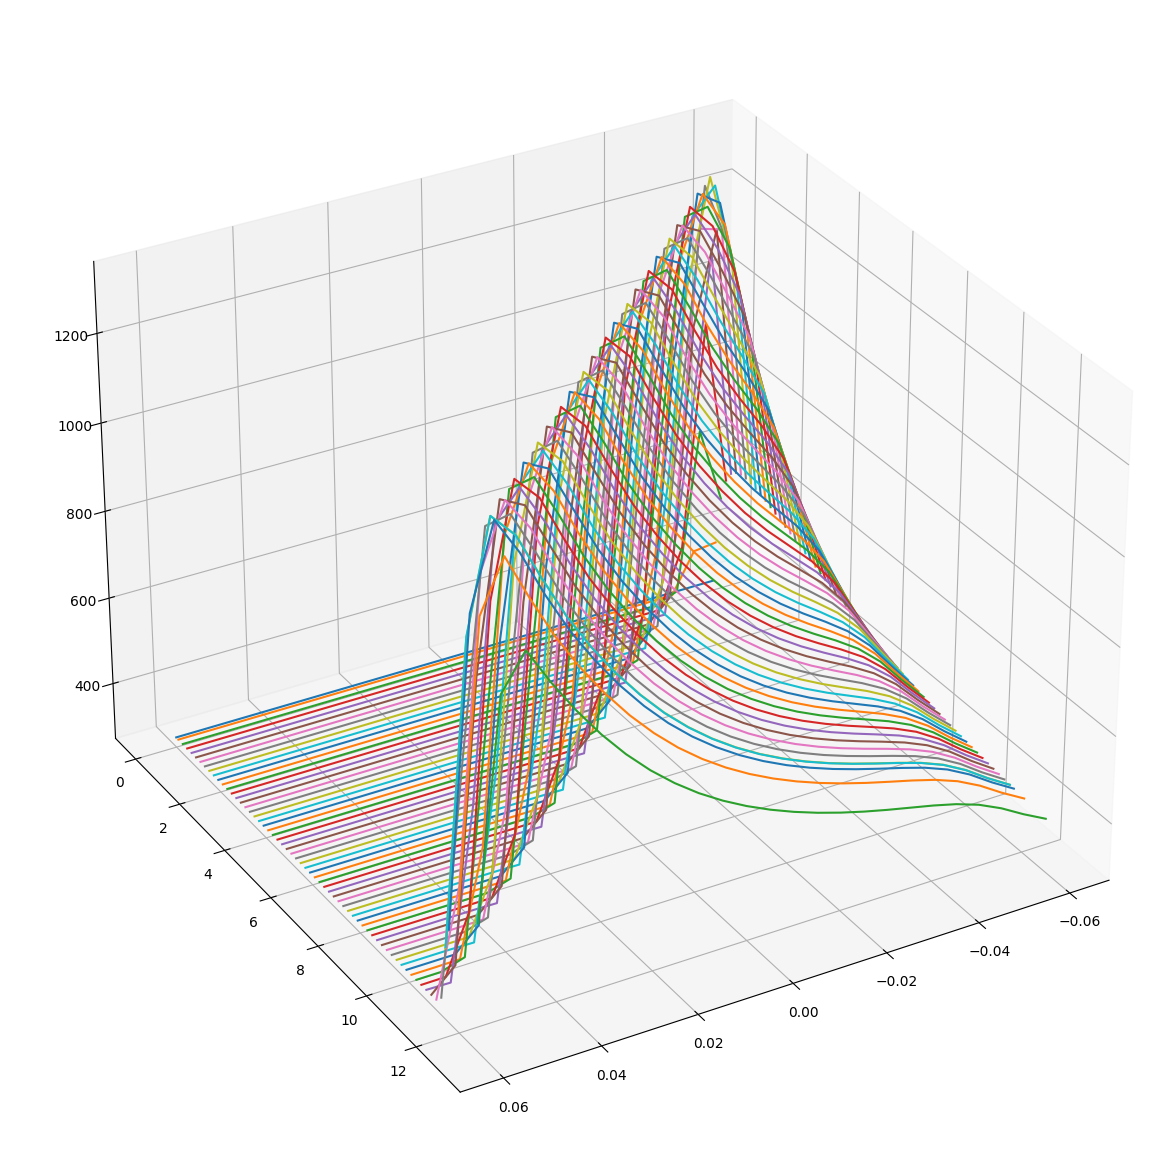

In [82]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for i in range(0, 63):
    ax.plot(coordinates[:, 0], 
            times[i][0]*np.ones(NUM_PARTICLES),
            temperatures[i, :])

ax.view_init(30, 60)
plt.show()

#### **x - t - zeta - phi**

In [83]:
X = None

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')

for i in range(0, NUM_PARTICLES):

    tt = times[:DEPOSITION_TIME_STEP, :]
    xx = np.array([coordinates[i:i+1, :1][0]]*tt.shape[0])
    yy = np.array([coordinates[i:i+1, 1:2][0]]*tt.shape[0])
    zz = np.array([coordinates[i:i+1, 2:3][0]]*tt.shape[0])
    zetazeta = (xx - (v*tt - 0.06))
    TT = temperatures[:DEPOSITION_TIME_STEP, i:i+1]
    pp = (TT - T_0) / np.exp(-(v*alpha*zz)/2)
    ff = np.hstack((xx, yy, zz, tt, zetazeta, pp, TT))

    if (i == 0):
        X_boundary_1 = ff
    elif (i == NUM_PARTICLES-1):
        X_boundary_2 = ff

    # ax.plot(tt, xx, TT)

    # ff = []
    # x_curr = coordinates[i, 0]
    # for j in range(DEPOSITION_TIME_STEP):
    #     t_curr = times[j, 0]
    #     z_curr = x_curr - (v*t_curr - 0.06)
    #     if (z_curr <= 0):
    #         T_curr =  temperatures[j, i]
    #         p_curr =  (T_curr - T_0) / np.exp(-(v*alpha*z_curr)/2)
    #     ff.append([x_curr, t_curr, z_curr, p_curr])

    # ff = np.array(ff)

    if X is None:
        X = ff
    else:
        X = np.vstack((X, ff))

# ax.view_init(30, -90)
# plt.show()

y = X[:, -2:-1]
# y = X[:, -1:]
X = X[:, :-2]

In [84]:
# X_extended = tf.Variable(X)
# y_extended = tf.Variable(X[:, -1:])

#### **Train Test Split**

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [86]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [87]:
# X_train = tf.data.Dataset.from_tensor_slices(tf.Variable(X_train))
# y_train = tf.data.Dataset.from_tensor_slices(tf.Variable(y_train))
# X_test = tf.data.Dataset.from_tensor_slices(tf.Variable(X_test))
# y_test = tf.data.Dataset.from_tensor_slices(tf.Variable(y_test))

X_train = tf.Variable(X_train)
y_train = tf.Variable(y_train)
X_test = tf.Variable(X_train)
y_test = tf.Variable(y_test)

### **Collocation Points**

In [88]:
X_collocation = X

In [89]:
# X_collocation = tf.data.Dataset.from_tensor_slices(tf.Variable(X_collocation, dtype=DTYPE))
X_collocation = tf.Variable(X_collocation)

### **Initial Condition Points**

In [90]:
X_initial = np.hstack((coordinates, np.zeros((coordinates.shape[0], 1)), coordinates[:, :1]+0.06))
y_initial = np.zeros(coordinates.shape)
# y_initial = np.ones(coordinates.shape)*T_0

In [91]:
# X_initial = tf.data.Dataset.from_tensor_slices(tf.Variable(X_initial, dtype=DTYPE))
# y_initial = tf.data.Dataset.from_tensor_slices(tf.Variable(y_initial, dtype=DTYPE))
X_initial = tf.Variable(X_initial)
y_initial = tf.Variable(y_initial)

### **Boundary Condition Points**

In [92]:
X_boundary_1 = tf.Variable(X_boundary_1)
X_boundary_2 = tf.Variable(X_boundary_2)
X_boundary_3 = tf.Variable(X)

### **Model**

In [93]:
inputParams = {
    INPUT_LAYER_DIM         : 5,
    OUTPUT_LAYER_DIM        : 1,
    HIDDEN_LAYERS_DIM       : [4, 8, 16, 8, 4],
    ANALYTICAL_SOLUTION     : analyticalSolution,
    RESIDUAL                : residual,
    EVALUATE_RESIDUAL       : evaluateResidual,
    EVALUATE_BOUNDARY_EQN_1 : evaluateBoundaryEqn_1,
    EVALUATE_BOUNDARY_EQN_2 : evaluateBoundaryEqn_2,
    EVALUATE_BOUNDARY_EQN_3 : evaluateBoundaryEqn_3,
    LEARNING_RATE           : 1e-2,
    EPOCHS                  : 1001,
    PRINT_INTERVAL          : 25,
    TRAINING_POINTS         : X_train,
    TRAINING_LABELS         : y_train,
    TEST_POINTS             : None,
    TEST_LABELS             : None,
    COLLOCATION_POINTS      : X_collocation,
    INITIAL_POINTS          : X_initial,
    INITIAL_LABELS          : y_initial,
    BOUNDARY_POINTS_1       : X_boundary_1,
    BOUNDARY_LABELS_1       : None,
    BOUNDARY_POINTS_2       : X_boundary_2,
    BOUNDARY_LABELS_2       : None,
    BOUNDARY_POINTS_3       : X_boundary_3,
    BOUNDARY_LABELS_3       : None,
    TRAINING_LOSS_WEIGHT    : 1,
    COLLOCATION_LOSS_WEIGHT : 1,
    INITIAL_LOSS_WEIGHT     : 1,
    BOUNDARY_LOSS_WEIGHT    : 1,
}

In [97]:
tf.keras.backend.clear_session()

In [98]:
model = PINN(inputParams)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 4)                 24        
                                                                 
 hidden_2 (Dense)            (None, 8)                 40        
                                                                 
 hidden_3 (Dense)            (None, 16)                144       
                                                                 
 hidden_4 (Dense)            (None, 8)                 136       
                                                                 
 hidden_5 (Dense)            (None, 4)                 36        
                                                                 
 output (Dense)              (None, 1)                 5         
                                                                 
Total params: 385
Trainable params: 385
Non-trainable pa

In [99]:
model.train()

It 00000: Train loss = 1.86419744e+12
It 00000: Collocation loss = 6.12740194e+09
It 00000: Initial loss = 6.72721412e-04
It 00000: Boundary Start loss = 3.66143383e+04
It 00000: Boundary End loss = 3.96430133e+04
It 00000: Boundary Bottom loss = 4.97256440e-02
It 00000: loss = 1.87032492e+12

It 00025: Train loss = 1.86419774e+12
It 00025: Collocation loss = 3.06145838e+07
It 00025: Initial loss = 2.82592124e-04
It 00025: Boundary Start loss = 1.68165022e+02
It 00025: Boundary End loss = 2.13263112e+02
It 00025: Boundary Bottom loss = 1.83144605e-04
It 00025: loss = 1.86422836e+12

It 00050: Train loss = 1.86419781e+12
It 00050: Collocation loss = 2.12137200e+06
It 00050: Initial loss = 2.02587325e-04
It 00050: Boundary Start loss = 1.06415323e+01
It 00050: Boundary End loss = 1.60638589e+01
It 00050: Boundary Bottom loss = 1.52275931e-04
It 00050: loss = 1.86419993e+12

It 00075: Train loss = 1.86419780e+12
It 00075: Collocation loss = 5.80545331e+05
It 00075: Initial loss = 1.892337

In [100]:
from sklearn.metrics import explained_variance_score
print(f"Neural Network Explained Variance: { explained_variance_score(y, model.model(X)):.4f}")

Neural Network Explained Variance: 0.0000


#### **$T_{model}(t)$ Visulatization**

In [101]:
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')

for i in range(0, 30):
    aaaa = coordinates[:, 0:1]
    bbbb = times[i][0]*np.ones((NUM_PARTICLES, 1))
    
    zzzz = (aaaa - (v*bbbb - 0.06))
    cccc = np.hstack((coordinates, bbbb, zzzz))
    dddd = model.model(tf.Variable(cccc)).numpy()
    
    TTTT = T_0 + dddd*np.exp(-(v*alpha*zzzz)/2)
    # print(f"Timestep : {i}")
    print(TTTT.reshape(-1))
    # print(dddd.reshape(-1))
    print("\n")
    # ax.plot(coordinates[:, 0], 
    #         times[i][0]*np.ones(NUM_PARTICLES),
    #         TTTT.reshape(-1))
    
    # tt = times[:DEPOSITION_TIME_STEP, :]
    # xx = np.array([coordinates[i:i+1, :][0]]*tt.shape[0])
    # zz = (xx - (v*tt - 0.06))
    # TT = temperatures[:DEPOSITION_TIME_STEP, i:i+1]
    # pp = (TT - T_0) / np.exp(-(v*alpha*zz)/2)
    # ff = np.hstack((xx, tt, zz, pp, TT))

# ax.view_init(30, 60)
# plt.show()

[293.15477752 293.15061242 293.15007857 293.15001009 293.1500013
 293.15000017 293.15000002 293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15      ]


[293.15603007 293.15075498 293.15009424 293.15001173 293.15000146
 293.15000018 293.15000002 293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15      ]


[293.16053874 293.15126894 293.15015076 293.15001761 293.15000201
 293.15000022 293.15000002 293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15
 293.15       293.15       293.15       293.15       293.15      ]


[293.17080411 293.15244828 293.15028197 293.15003153 293